In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
import numpy as np
import pandas as pd
import math
import sys

from IPython.core.debugger import Tracer

In [4]:
def plot(x, y, leg_labels, cnt = 3):
    fig, ax = plt.subplots(figsize = (30, 30))
    
    green_patch = mpatches.Patch(color='green', label=leg_labels[0])
    red_patch = mpatches.Patch(color='red', label=leg_labels[1])
    blue_patch = mpatches.Patch(color='blue', label=leg_labels[2])
    plt.legend(handles=[green_patch, red_patch, blue_patch], prop={'size':30}, loc=2)

    ax.plot(x, list(map(lambda ys: ys[0], y)), color='g')
    ax.plot(x, list(map(lambda ys: ys[1], y)), color='r')
    ax.plot(x, list(map(lambda ys: ys[2], y)), color='b')


In [5]:
data = pd.read_csv("data.csv", index_col="Ind.", sep=",")

In [65]:
P_A = 1e5 # atmosphere pressure WARNING (can be not 1e5)
R = 8.314
delta = 0.1

p_Al = 2690
p_Ga = 5900
p_AlN = 3200
p_GaN = 6150

def init():
    global P_A
    
    x = lambda T: T / 1e4
    
    data["sigmaN2"] = (data["sigma"] + data["sigma"]["N2"]) / 2.0
    data["epsilonN2"] = np.sqrt(data["epsilon"] * data["epsilon"]["N2"])
    data["muN2"] =  2 * data["mu"]["N2"] * data["mu"] / (data["mu"]["N2"] + data["mu"])
    
    def generate(subst):
        data.loc[subst, "omega"] = lambda T: 1.074 * np.power(T / data["epsilonN2"][subst], -0.1604)        
        data.loc[subst, "Phi"] = lambda T: \
                      data["f1"][subst] \
                    + data["f2"][subst] * np.log(x(T)) \
                    + data["f3"][subst] * np.power(x(T), -2.0) \
                    + data["f4"][subst] * np.power(x(T), -1.0) \
                    + data["f5"][subst] * x(T) \
                    + data["f6"][subst] * np.power(x(T), 2.0) \
                    + data["f7"][subst] * np.power(x(T), 3.0)
                    
        data.loc[subst, "G"] = lambda T: data["H(298)"][subst] - data["Phi"][subst](T) * T
        
        data.loc[subst, "D"] = lambda T: 2.628e-2 * np.power(T, 3.0 / 2.0) / \
                        (P_A * data["sigmaN2"][subst] * data["omega"][subst](T) * np.sqrt(data["muN2"][subst]))
            
    closure = [generate(subst) for subst in data.index]
    
init()

In [7]:
K = [lambda T: np.exp(-(2 * data["G"]["Al"](T)
                        + 2 * data["G"]["HCl"](T)
                        - 2 * data["G"]["AlCl"](T) 
                        - data["G"]["H2"](T)) / (R * T)) / P_A,
     
     lambda T: np.exp(-(data["G"]["Al"](T) 
                        + 2 * data["G"]["HCl"](T) 
                        - data["G"]["AlCl2"](T) 
                        - data["G"]["H2"](T)) / (R * T)),
     
     lambda T: np.exp(-(2 * data["G"]["Al"](T) 
                        + 6 * data["G"]["HCl"](T) 
                        - 2 * data["G"]["AlCl3"](T) 
                        - 3 * data["G"]["H2"](T)) / (R * T)) * P_A,
     
     lambda T: np.exp(-(2 * data["G"]["Ga"](T) 
                        + 2 * data["G"]["HCl"](T) 
                        - 2 * data["G"]["GaCl"](T) 
                        - data["G"]["H2"](T)) / (R * T)) / P_A,
     
     lambda T: np.exp(-(data["G"]["Ga"](T) 
                        + 2 * data["G"]["HCl"](T) 
                        - data["G"]["GaCl2"](T) 
                        - data["G"]["H2"](T)) / (R * T)),
     
     lambda T: np.exp(-(2 * data["G"]["Ga"](T) 
                        + 6 * data["G"]["HCl"](T) 
                        - 2 * data["G"]["GaCl3"](T) 
                        - 3 * data["G"]["H2"](T)) / (R * T)) * P_A,
     
     lambda T: 0,
     
     lambda T: 0,
     
     lambda T: np.exp(-(data["G"]["AlCl3"](T) 
                        + data["G"]["NH3"](T) 
                        - data["G"]["AlN"](T) 
                        - 3 * data["G"]["HCl"](T)) / (R * T)) / P_A,
     
     lambda T: np.exp(-(data["G"]["GaCl"](T)  
                        + data["G"]["NH3"](T) 
                        - data["G"]["GaN"](T) 
                        - data["G"]["HCl"](T) 
                        - data["G"]["H2"](T)) / (R * T)),
     
     lambda T : 0,
     
     lambda T : 0
    ]

In [8]:
def apply_matrix(J, x):
    return np.array([[J[i][j](x) for j in range(J.shape[1])] for i in range(J.shape[0])])

def apply_vector(J, x):
    return np.array([J[i](x) for i in range(J.shape[0])])

def inv(J):
    return np.linalg.inv(J)

def newton_method(J, f, start, max_iter = int(1e5), eps = 1e-7):
    x = start
    for it in range(max_iter):
        J_cur = apply_matrix(J, x)
        f_cur = apply_vector(f, x)
        nx = x - inv(J_cur).dot(f_cur)
        if (np.linalg.norm(nx - x) < eps):
            print("iterations to converge = %d" % (it))
            return x
        x = nx
    assert(False)

In [ ]:
def test_newton():
    Tracer()()
    f = \
    [
        lambda x: x[0] + x[1] - 4,
        lambda x: x[0] - x[1]
    ]
    J = \
    [
        [
            lambda x: 1,
            lambda x: 1
        ],
        [
            lambda x: 1,
            lambda x: -1
        ]
    ]

    print(newton_method(np.array(J), np.array(f), np.array([5.3, 1205363])))

In [37]:
# Task1
# 0 -- AlCl
# 1 -- AlCl2
# 2 -- AlCl3
# 3 -- H2
# 4 -- HCl

def solve(T):
    
    subs = ["AlCl", "AlCl2", "AlCl3", "H2", "HCl"]
    
    data.loc["AlCl", "Pg"] = 0
    data.loc["AlCl2", "Pg"] = 0
    data.loc["AlCl3", "Pg"] = 0
    data.loc["H2", "Pg"] = 0
    data.loc["HCl", "Pg"] = 1e4
    
    # Jacobian
    J = \
    [ 
        [ # 0 :::  (PHCl ** 2) - K0 * (PAlCl ** 2) * PH2 = 0
            lambda x: 0 - 2 * K[0](T) * x[0] * x[3], 
            lambda x: 0, 
            lambda x: 0, 
            lambda x: 0 - K[0](T) * x[0] * x[0], 
            lambda x: 2 * x[4]
        ],
    
        [ # 1 ::: (PHCl ** 2) - K1 * PAlCl2 * PH2 = 0
            lambda x: 0, 
            lambda x: 0 - K[1](T) * x[3], 
            lambda x: 0, 
            lambda x: 0 - K[1](T) * x[1], 
            lambda x: 2 * x[4] 
        ],
        
        [ # 2 ::: (PHCl ** 6) - K2 * (PAlCl3 ** 2) * (PH2 ** 3) = 0
            lambda x: 0,
            lambda x: 0,
            lambda x: 0 - 2 * K[2](T) * x[2] * (x[3] ** 3),
            lambda x: 0 - 3 * K[2](T) * (x[2] ** 2) * (x[3] ** 2),
            lambda x: 6 * (x[4] ** 5)
        ],
    
        [ # 3 ::: DHCl(PgHCl - PeHCl) + 2 * DH2 * (PgH2 - PeH2) = 0
            lambda x: 0,
            lambda x: 0,
            lambda x: 0,
            lambda x: -2 * data["D"]["H2"](T),
            lambda x: -1 * data["D"]["HCl"](T),        
        ],
        
        [   # 4 ::: DAlCl(Pg(AlCl) - Pe(AlCl)) 
            #   + 2 * D(AlCl2)(Pg(AlCl2) - Pe(AlCl2)) 
            #   + 3 * D(AlCl3) * (Pg(AlCl3) - Pe(AlCl3)) 
            #   + D(HCl) * (Pg(HCl) - Pe(HCl)) = 0

            lambda x: -data["D"]["AlCl"](T),
            lambda x: -2 * data["D"]["AlCl2"](T),
            lambda x: -3 * data["D"]["AlCl3"](T),
            lambda x: 0,
            lambda x: -data["D"]["HCl"](T)
        ]
    ]

    f = \
    [
    # (PHCl ** 2) - K0 * (PAlCl ** 2) * PH2 = 0
        lambda x: (x[4] ** 2) - K[0](T) * (x[0] ** 2) * x[3]
    ,
    # 1 ::: (PHCl ** 2) - K1 * PAlCl2 * PH2 = 0
        lambda x: (x[4] ** 2) - K[1](T) * x[1] * x[3]
    ,
    # 2 ::: (PHCl ** 6) - K2 * (PAlCl3 ** 2) * (PH2 ** 3) = 0
        lambda x: (x[4] ** 6) - K[2](T) * (x[2] ** 2) * (x[3] ** 3)
    ,
    # 3 ::: D(HCl) * (Pg(HCl) - Pe(HCl)) + 2 * D(H2) * (Pg(H2) - Pe(H2)) = 0
        lambda x: data["D"]["HCl"](T) * (data["Pg"]["HCl"] - x[4]) \
                    + 2 * data["D"]["H2"](T) * (data["Pg"]["H2"] - x[3])
    ,
    # 4 ::: DAlCl(Pg(AlCl) - Pe(AlCl)) 
      #   + 2 * D(AlCl2)(Pg(AlCl2) - Pe(AlCl2)) 
      #   + 3 * D(AlCl3) * (Pg(AlCl3) - Pe(AlCl3)) 
      #   + D(HCl) * (Pg(HCl) - Pe(HCl)) = 0
        lambda x: data["D"]["AlCl"](T) * (data["Pg"]["AlCl"] - x[0]) \
              + 2 * data["D"]["AlCl2"](T) * (data["Pg"]["AlCl2"] - x[1]) \
              + 3 * data["D"]["AlCl3"](T) * (data["Pg"]["AlCl3"] - x[2]) \
              + data["D"]["HCl"](T) * (data["Pg"]["HCl"] - x[4])
    ]

    start = [1,2,3,4,5]
    x = newton_method(np.array(J), np.array(f), start)

    for i in range(len(subs)):
        data.loc[subs[i], "PeAl"] = x[i]
    
    for s in subs:
        data.loc[s, "G_flowAl"] = data.loc[s, "D"](T) * (data.loc[s, "Pg"] - data.loc[s, "PeAl"]) / (R * T * delta)
    
    V_Al = ((data.loc["AlCl", "G"](T) + data.loc["AlCl2", "G"](T) + data.loc["AlCl3", "G"](T)) * data["mu"]["Al"] / p_Al) * 1e9
        
    return [[data.loc[s, "G_flowAl"] for s in subs], V_Al]

t_cs = np.linspace(350, 650, 20)
res = [solve(t_c + 273.15) for t_c in t_cs]
y = [list(map(lambda el: np.log(-el), cr[0])) for cr in res]
x = [1 / (t_c + 273.15) for t_c in t_cs]

iterations to converge = 57
iterations to converge = 54
iterations to converge = 52
iterations to converge = 49
iterations to converge = 47
iterations to converge = 45
iterations to converge = 43
iterations to converge = 41
iterations to converge = 39
iterations to converge = 37
iterations to converge = 36
iterations to converge = 34
iterations to converge = 32
iterations to converge = 31
iterations to converge = 29
iterations to converge = 28
iterations to converge = 28
iterations to converge = 28
iterations to converge = 28
iterations to converge = 28


/usr/lib/python3.5/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in log


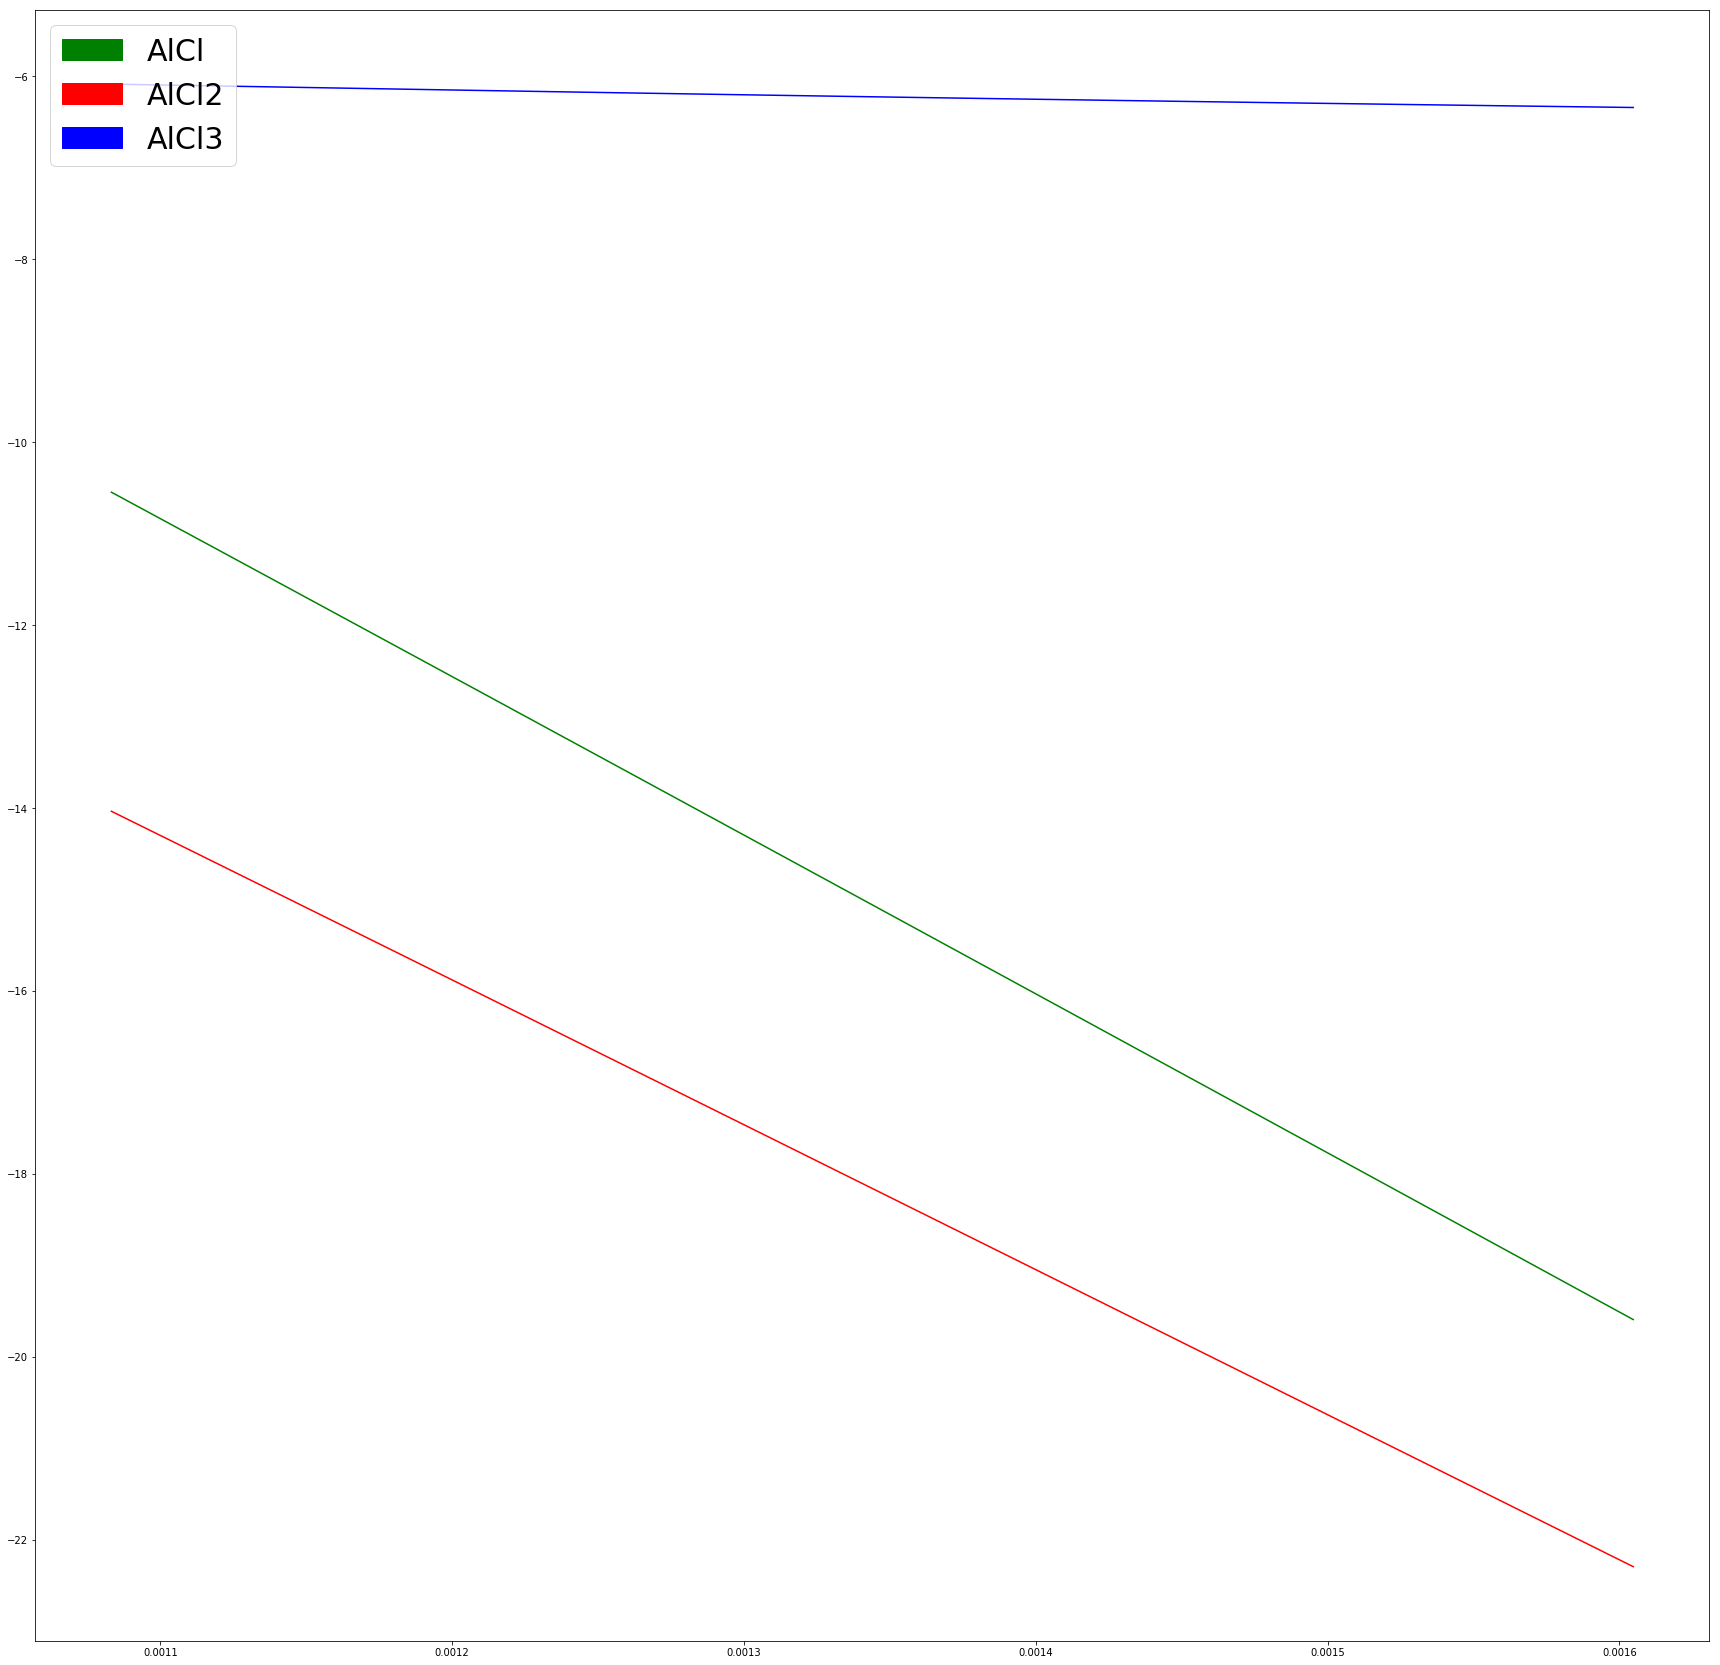

In [53]:
plot(x, y, leg_labels = ["AlCl", "AlCl2", "AlCl3"])

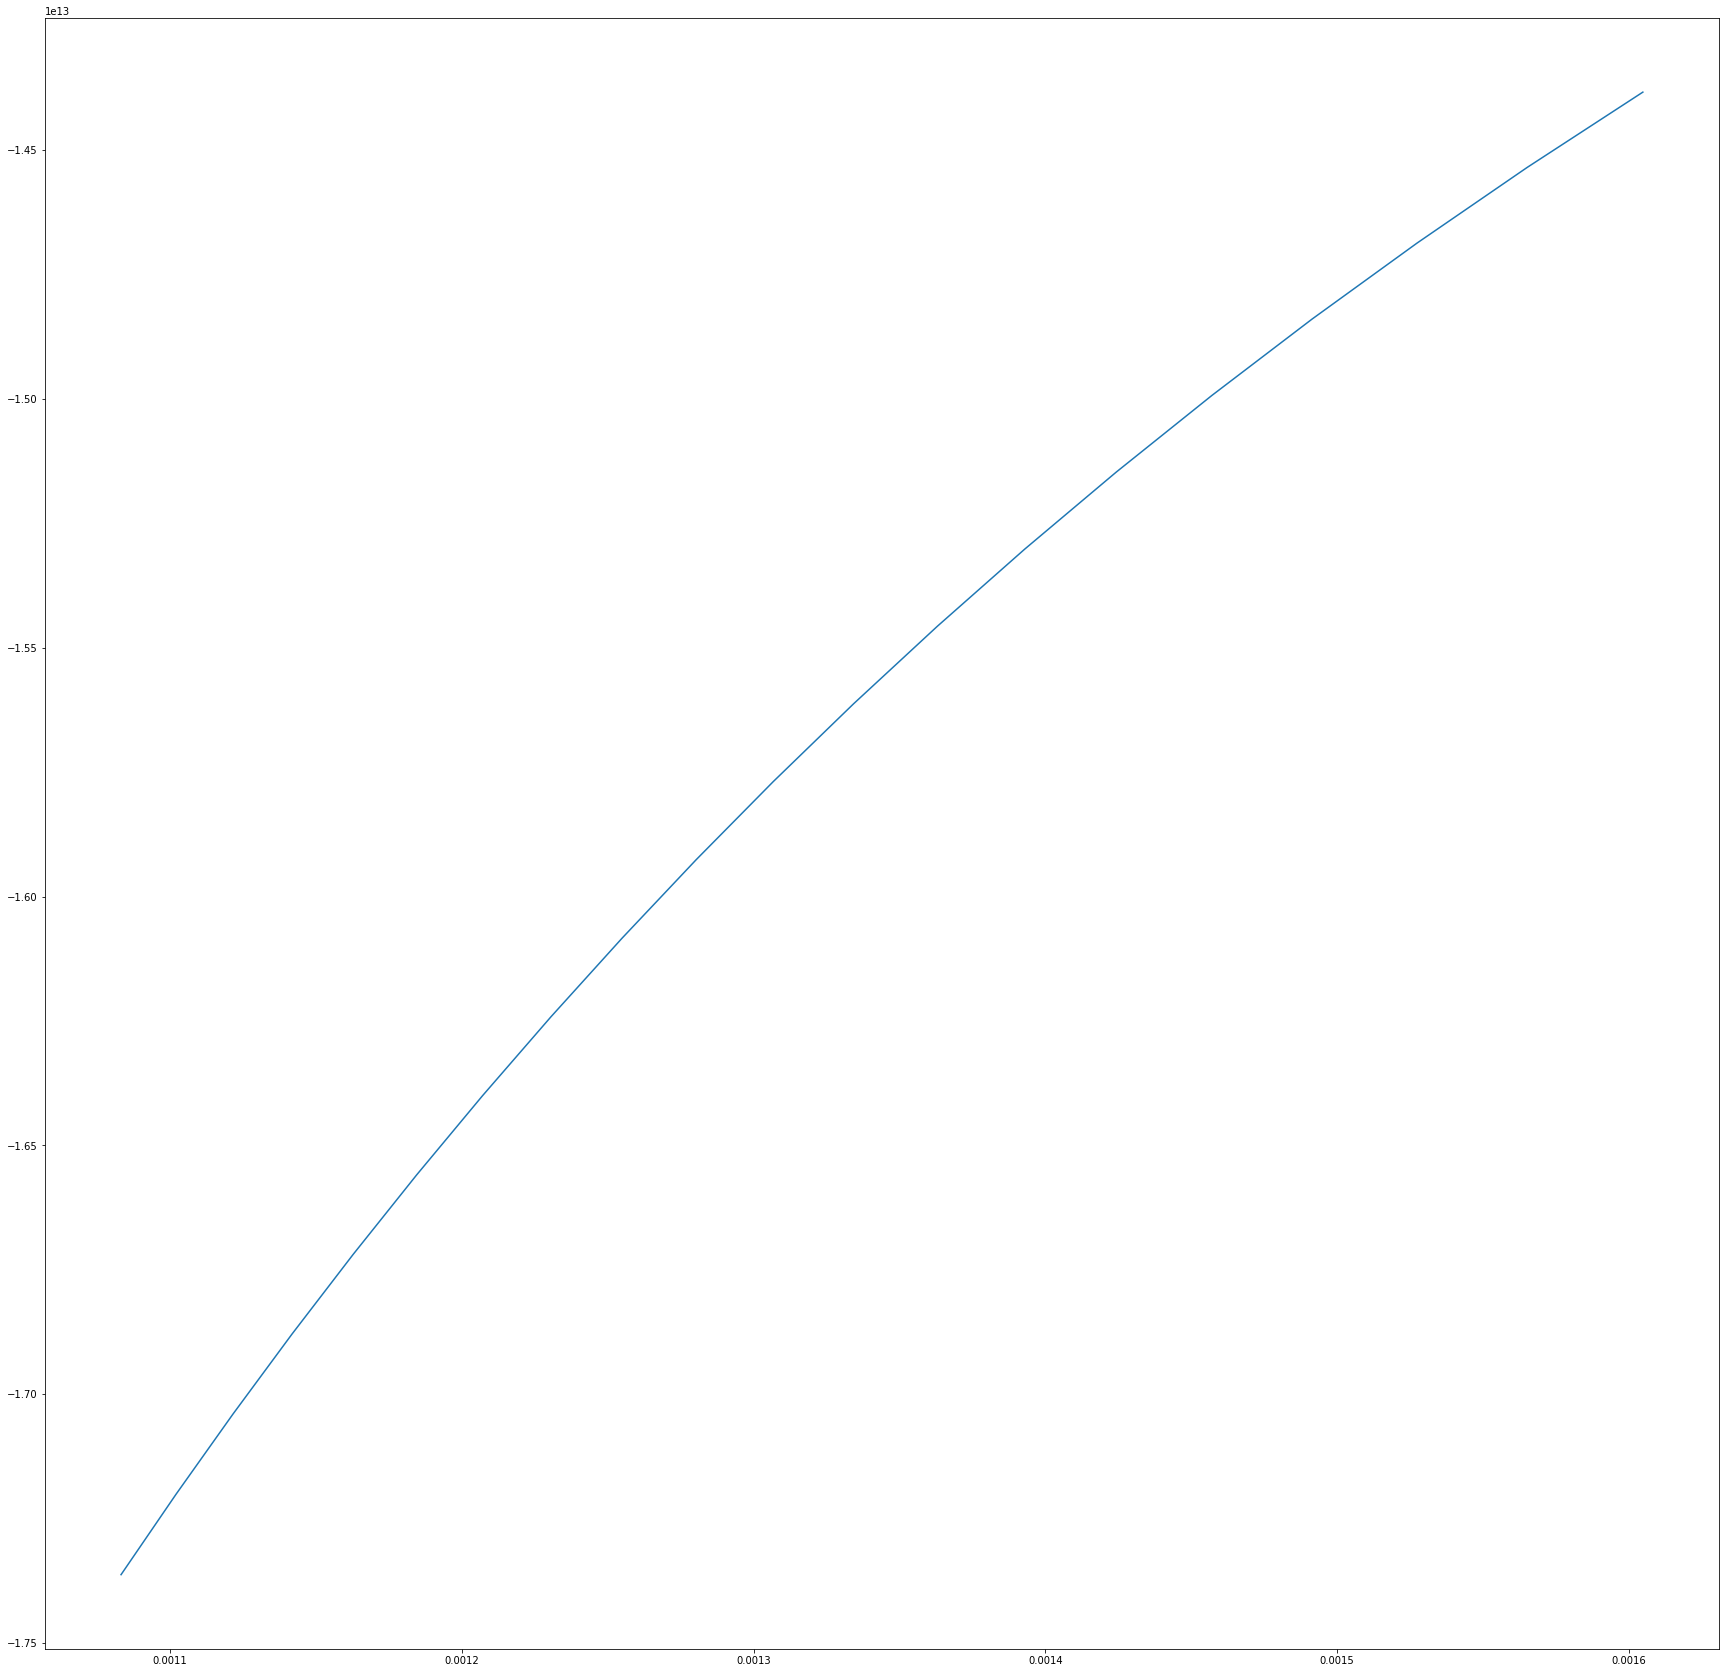

In [54]:
y2 = [res[i][1] for i in range(len(res))]
fig, ax = plt.subplots(figsize = (30, 30))
ax.plot(x, y2)

In [62]:
# 0 -- GaCl
# 1 -- GaCl2
# 2 -- GaCl3
# 3 -- H2
# 4 -- HCl

def solve(T):
    
    subs = ["GaCl", "GaCl2", "GaCl3", "H2", "HCl"]
    
    data.loc["GaCl", "Pg"] = 0
    data.loc["GaCl2", "Pg"] = 0
    data.loc["GaCl3", "Pg"] = 0
    data.loc["H2", "Pg"] = 0
    data.loc["HCl", "Pg"] = 1e4
    
    # Jacobian
    J = \
    [ 
        [ # 0 :::  (P(HCl) ** 2) - K3 * (P(GaCl) ** 2) * P(H2) = 0
            lambda x: 0 - 2 * K[3](T) * x[0] * x[3], 
            lambda x: 0, 
            lambda x: 0, 
            lambda x: 0 - K[3](T) * x[0] * x[0], 
            lambda x: 2 * x[4]
        ],
    
        [ # 1 ::: (P(HCl) ** 2) - K4 * P(GaCl2) * P(H2) = 0
            lambda x: 0, 
            lambda x: 0 - K[4](T) * x[3], 
            lambda x: 0, 
            lambda x: 0 - K[4](T) * x[1], 
            lambda x: 2 * x[4] 
        ],
        
        [ # 2 ::: (P(HCl) ** 6) - K5 * (P(GaCl3) ** 2) * (P(H2) ** 3) = 0
            lambda x: 0,
            lambda x: 0,
            lambda x: 0 - 2 * K[5](T) * x[2] * (x[3] ** 3),
            lambda x: 0 - 3 * K[5](T) * (x[2] ** 2) * (x[3] ** 2),
            lambda x: 6 * (x[4] ** 5)
        ],
    
        [ # 3 ::: D(HCl)(Pg(HCl) - Pe(HCl)) + 2 * D(H2) * (Pg(H2) - Pe(H2)) = 0
            lambda x: 0,
            lambda x: 0,
            lambda x: 0,
            lambda x: -2 * data["D"]["H2"](T),
            lambda x: -1 * data["D"]["HCl"](T),        
        ],
        
        [   # 4 ::: D(GaCl)(Pg(GaCl) - Pe(GaCl)) 
            #   + 2 * D(GaCl2)(Pg(GaCl2) - Pe(GaCl2)) 
            #   + 3 * D(GaCl3) * (Pg(GaCl3) - Pe(GaCl3)) 
            #   + D(HCl) * (Pg(HCl) - Pe(HCl)) = 0

            lambda x: -data["D"]["GaCl"](T),
            lambda x: -2 * data["D"]["GaCl2"](T),
            lambda x: -3 * data["D"]["GaCl3"](T),
            lambda x: 0,
            lambda x: -data["D"]["HCl"](T)
        ]
    ]
    
    f = \
    [
    # (PHCl ** 2) - K3 * (PGaCl ** 2) * PH2 = 0
        lambda x: (x[4] ** 2) - K[3](T) * (x[0] ** 2) * x[3]
    ,
    # 1 ::: (PHCl ** 2) - K4 * PGaCl2 * PH2 = 0
        lambda x: (x[4] ** 2) - K[4](T) * x[1] * x[3]
    ,
    # 2 ::: (PHCl ** 6) - K5 * (PGaCl3 ** 2) * (PH2 ** 3) = 0
        lambda x: (x[4] ** 6) - K[5](T) * (x[2] ** 2) * (x[3] ** 3)
    ,
    # 3 ::: D(HCl) * (Pg(HCl) - Pe(HCl)) + 2 * D(H2) * (Pg(H2) - Pe(H2)) = 0
        lambda x: data["D"]["HCl"](T) * (data["Pg"]["HCl"] - x[4]) \
                    + 2 * data["D"]["H2"](T) * (data["Pg"]["H2"] - x[3])
    ,
    # 4 ::: D(GaCl)(Pg(GaCl) - Pe(GaCl)) 
    #   + 2 * D(GaCl2)(Pg(GaCl2) - Pe(GaCl2)) 
    #   + 3 * D(GaCl3) * (Pg(GaCl3) - Pe(GaCl3)) 
    #   + D(HCl) * (Pg(HCl) - Pe(HCl)) = 0        
        lambda x: data["D"]["GaCl"](T) * (data["Pg"]["GaCl"] - x[0]) \
              + 2 * data["D"]["GaCl2"](T) * (data["Pg"]["GaCl2"] - x[1]) \
              + 3 * data["D"]["GaCl3"](T) * (data["Pg"]["GaCl3"] - x[2]) \
              + data["D"]["HCl"](T) * (data["Pg"]["HCl"] - x[4])
    ]

    
    start = [1, 1, 1, 1, 1]
    x = newton_method(np.array(J), np.array(f), start)
    
    
#     print(delta)
#     x = [0, 0, 0, 0, 0]
#     cnt_iterations = 10
#     for ii in range(cnt_iterations):
#         print("iteration: %d" % (ii))
#         start = np.random.randint(1, 1000, 5)
#         cur_x = newton_method(np.array(J), np.array(f), start)
#         x += cur_x
#     x /= cnt_iterations

    for i in range(len(subs)):
        data.loc[subs[i], "PeGa"] = x[i]
    
    for s in subs:
        data.loc[s, "G_flowGa"] = data.loc[s, "D"](T) * (data.loc[s, "Pg"] - data.loc[s, "PeGa"]) / (R * T * delta)
        
    V_Ga = ((data.loc["GaCl", "G"](T) + data.loc["GaCl2", "G"](T) + data.loc["GaCl3", "G"](T)) * data["mu"]["Ga"] / p_Ga) * 1e9


    return [[data.loc[s, "G_flowGa"] for s in subs], V_Ga]


t_cs = np.linspace(650, 950, 20)
res = [solve(t_c + 273.15) for t_c in t_cs]
y = [list(map(lambda el: np.log(-el), cr[0])) for cr in res]
x = [1 / (t_c + 273.15) for t_c in t_cs]

iterations to converge = 23
iterations to converge = 22
iterations to converge = 21
iterations to converge = 20
iterations to converge = 19
iterations to converge = 17
iterations to converge = 17
iterations to converge = 18
iterations to converge = 19
iterations to converge = 19
iterations to converge = 20
iterations to converge = 20
iterations to converge = 20
iterations to converge = 21
iterations to converge = 21
iterations to converge = 22
iterations to converge = 22
iterations to converge = 22
iterations to converge = 23
iterations to converge = 23


/usr/lib/python3.5/site-packages/ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in log


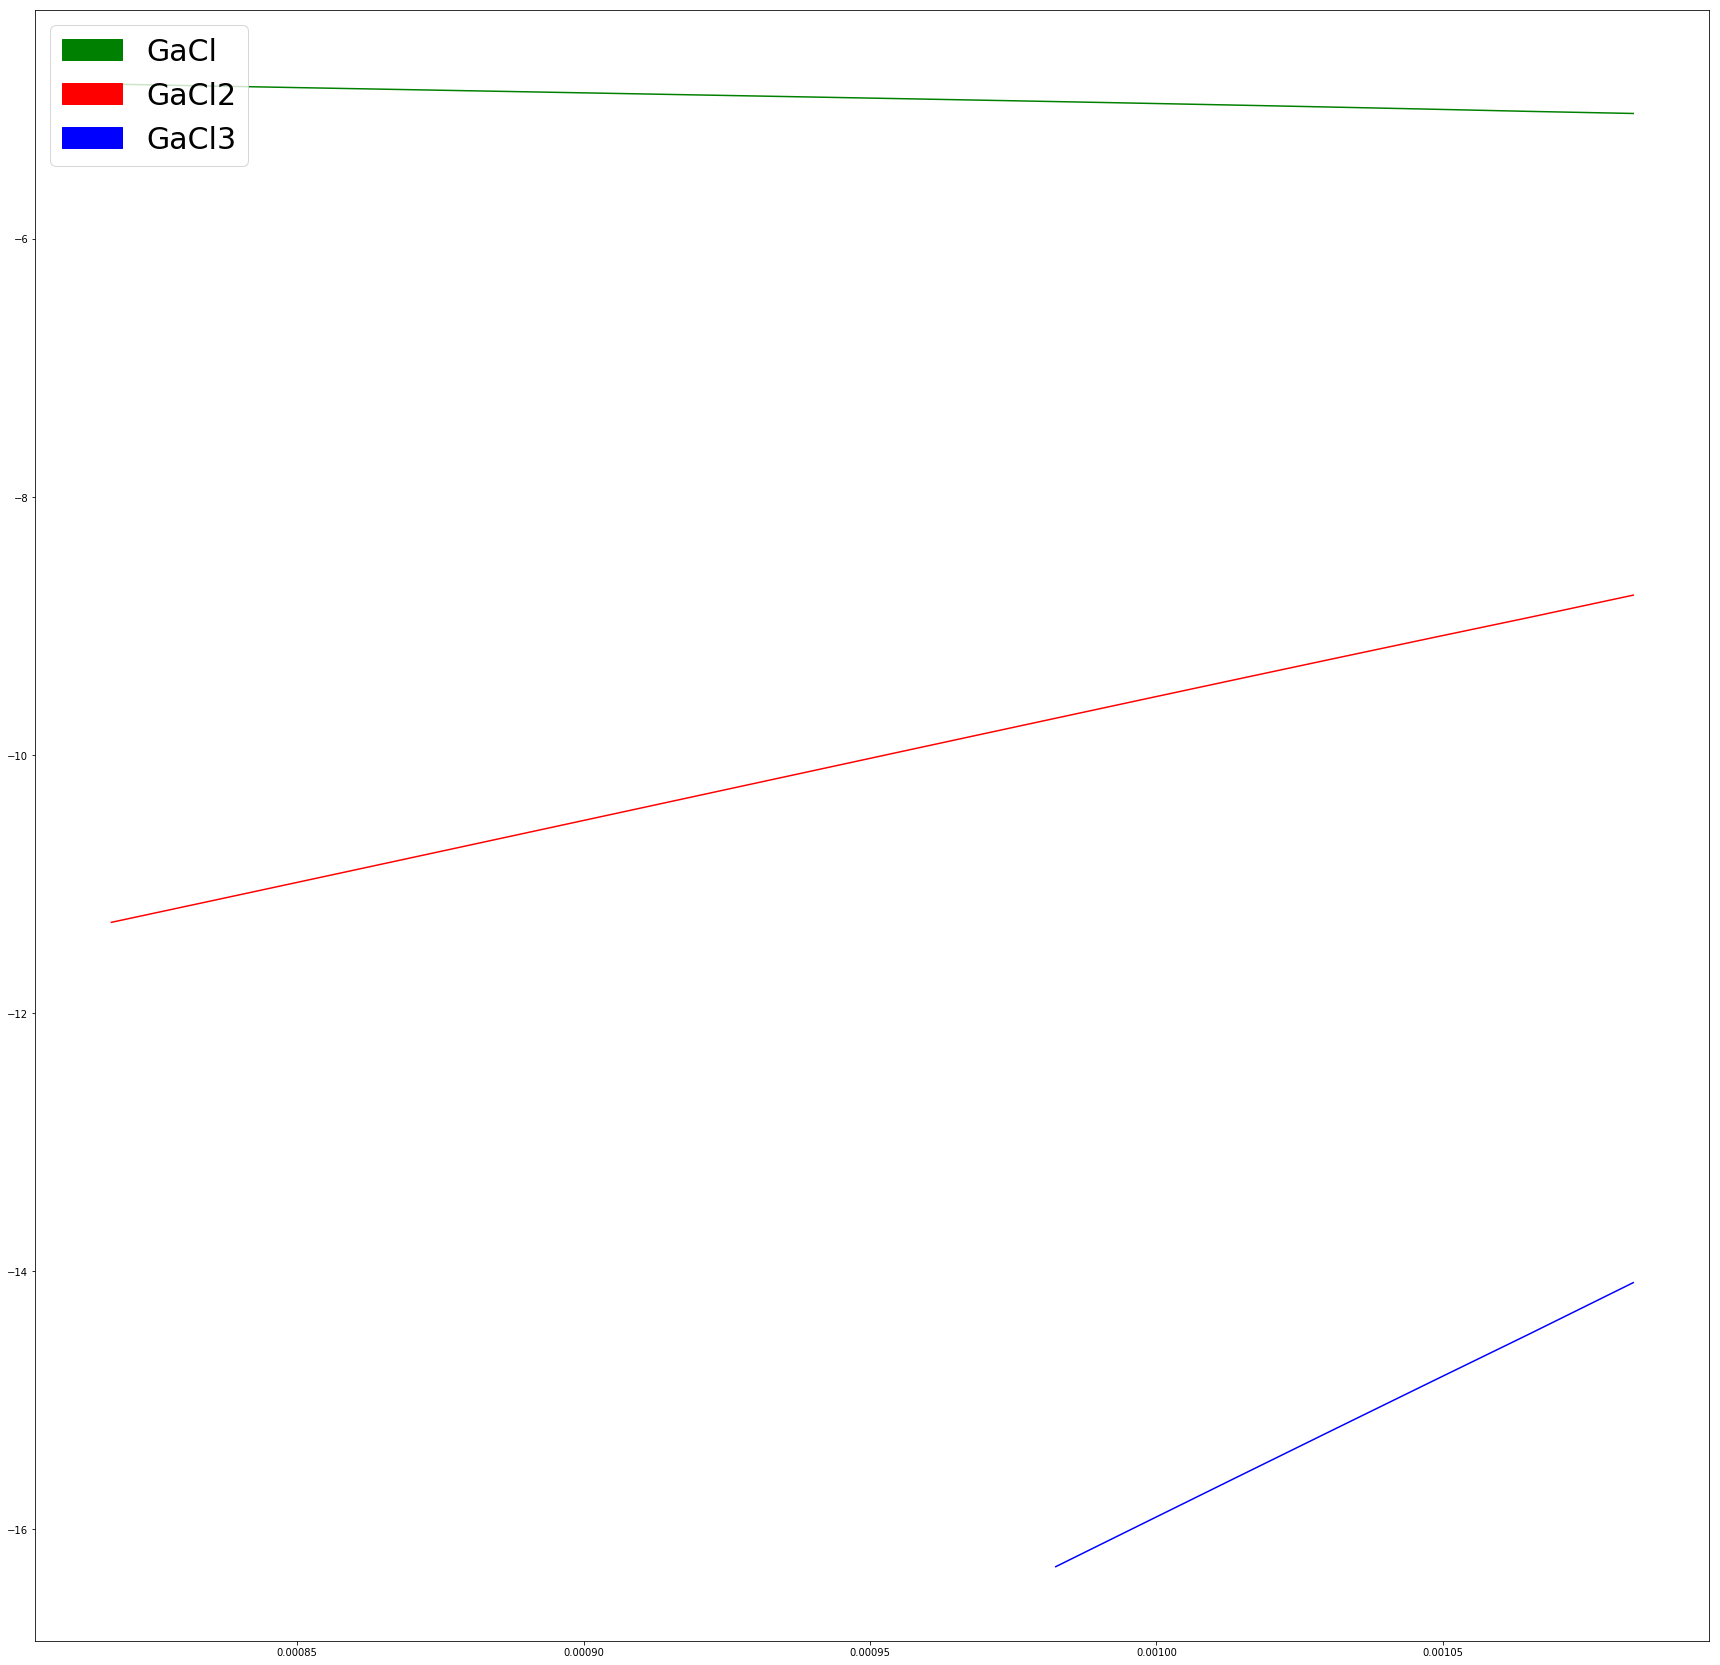

In [63]:
plot(x, y, leg_labels=["GaCl", "GaCl2", "GaCl3"])

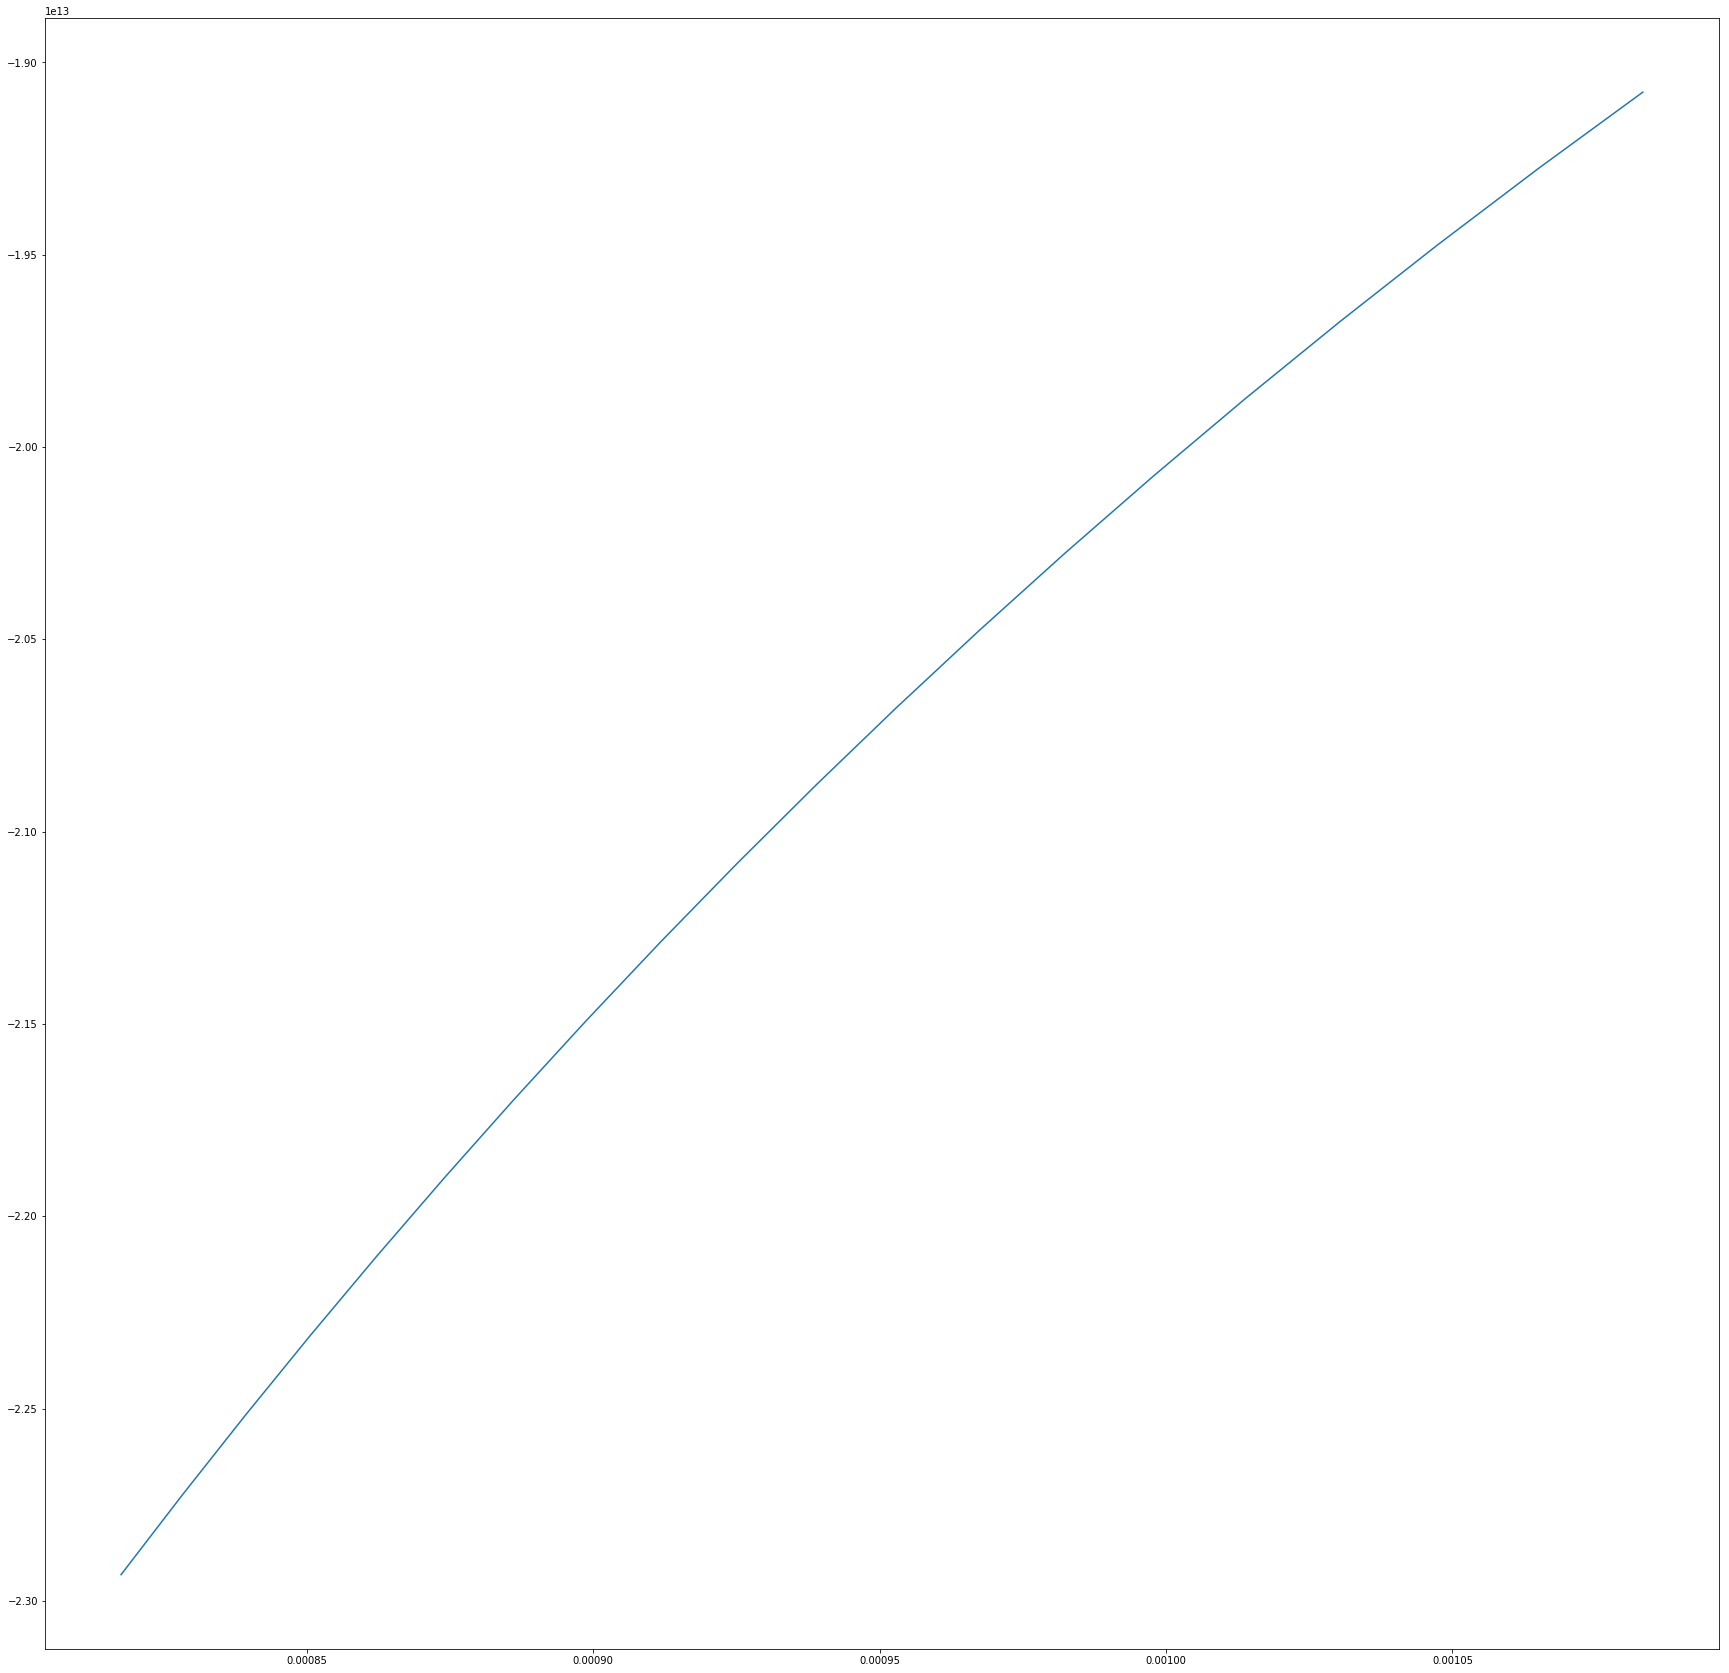

In [64]:
y2 = [res[i][1] for i in range(len(res))]
fig, ax = plt.subplots(figsize = (30, 30))
ax.plot(x, y2)

In [76]:
# Task3
# 0 -- AlCl3
# 1 -- GaCl
# 2 -- NH3
# 3 -- H2
# 4 -- HCl
# 5 -- x

def solve(T, coeff, coeffH2):
    
    subs = ["AlCl3", "GaCl", "NH3", "HCl", "H2"]

    data.loc["AlCl3", "Pg"] = 30 * coeff
    data.loc["GaCl", "Pg"] = 30 * (1 - coeff)
    data.loc["NH3", "Pg"] = 1500
    data.loc["H2", "Pg"] = 98470 * coeffH2
    data.loc["HCl", "Pg"] = 0
    data.loc["N2", "Pg"] = 98470 * (1 - coeffH2)
    
    # Jacobian
    J = \
    [ 
        [ # 0 :::  (P(AlCl3) * P(NH3) - K9 * x * (P(HCl) ** 3)) = 0
            lambda x: x[2],
            lambda x: 0, 
            lambda x: x[0], 
            lambda x: 0, 
            lambda x: -3 * K[8](T) * x[5] * (x[4] ** 2),
            lambda x: -K[8](T) * (x[4] ** 3)
        ],
    
        [ # 1 ::: (P(GaCl) * P(NH3) - K10 * (1 - x) * P(HCl) * P(H2))
            lambda x: 0, 
            lambda x: x[2], 
            lambda x: x[1], 
            lambda x: -K[9](T) * (1 - x[5]) * x[4], 
            lambda x: -K[9](T) * (1 - x[5]) * x[3],
            lambda x: K[9](T) * x[3] * x[4]
        ],
    
        [ # 2 ::: D(HCl) * (Pg(HCl) - Pe(HCl)) + 2D(H2) * (Pg(H2) - Pe(H2)) + 3D(NH3) * (Pg(NH3) - Pe(NH3)) = 0
            lambda x: 0, 
            lambda x: 0, 
            lambda x: -3 * data["D"]["NH3"](T), 
            lambda x: -2 * data["D"]["H2"](T), 
            lambda x: -data["D"]["HCl"](T),
            lambda x: 0
        ],
    
        [ # 3 ::: 3 * D(AlCl3) * (Pg(AlCl3) - Pe(AlCl3)) + D(GaCl) * (Pg(GaCl) - Pe(GaCl)) + D(HCl) * (Pg(HCl) - Pe(HCl)) = 0
            lambda x: -3 * data["D"]["AlCl3"](T),
            lambda x: -data["D"]["GaCl"](T),
            lambda x: 0, 
            lambda x: 0, 
            lambda x: -data["D"]["HCl"](T),
            lambda x: 0
        ],
        
        [ # 4 ::: D(AlCl3) * (Pg(AlCl3) - Pe(AlCl3)) + D(GaCl) * (Pg(GaCl) - Pe(GaCl)) - D(NH3) * (Pg(NH3) - Pe(NH3)) = 0
            lambda x: -data["D"]["AlCl3"](T), 
            lambda x: -data["D"]["GaCl"](T),
            lambda x: data["D"]["NH3"](T), 
            lambda x: 0, 
            lambda x: 0,
            lambda x: 0
        ], 
        
        [ # 5 ::: D(AlCl3) * (Pg(AlCl3) - Pe(AlCl3)) * (1 - x) - D(GaCl) * (Pg(GaCl) - Pe(GaCl)) * x = 0
            lambda x: -data["D"]["AlCl3"](T) * (1 - x[5]), 
            lambda x: data["D"]["GaCl"](T) * x[5],
            lambda x: 0, 
            lambda x: 0, 
            lambda x: 0,
            lambda x: -data["D"]["AlCl3"](T) * (data["Pg"]["AlCl3"] - x[0]) 
                      -data["D"]["GaCl"](T) * (data["Pg"]["GaCl"] - x[1])
        ]
    ]

    f = \
    [
        # 0 :::  (P(AlCl3) * P(NH3) - K9 * x * (P(HCl) ** 3)) = 0
        lambda x: x[0] * x[2] - K[8](T) * x[5] * (x[4] ** 3)
        ,
        # 1 ::: (P(GaCl) * P(NH3) - K10 * (1 - x) * P(HCl) * P(H2))
        lambda x: x[1] * x[2] - K[9](T) * (1 - x[5]) * x[4] * x[3]
        ,
        # 2 ::: D(HCl) * (Pg(HCl) - Pe(HCl)) + 2D(H2) * (Pg(H2) - Pe(H2)) + 3D(NH3) * (Pg(NH3) - Pe(NH3)) = 0
        lambda x: data["D"]["HCl"](T) * (data["Pg"]["HCl"] - x[4])
                + 2 * data["D"]["H2"](T) * (data["Pg"]["H2"] - x[3])
                + 3 * data["D"]["NH3"](T) * (data["Pg"]["NH3"] - x[2])
        ,
        # 3 ::: 3 * D(AlCl3) * (Pg(AlCl3) - Pe(AlCl3)) + D(GaCl) * (Pg(GaCl) - Pe(GaCl)) + D(HCl) * (Pg(HCl) - Pe(HCl)) = 0
        lambda x: 3 * data["D"]["AlCl3"](T) * (data["Pg"]["AlCl3"] - x[0])
                + data["D"]["GaCl"](T) * (data["Pg"]["GaCl"] - x[1])
                + data["D"]["HCl"](T) * (data["Pg"]["HCl"] - x[4])
        ,
        # 4 ::: D(AlCl3) * (Pg(AlCl3) - Pe(AlCl3)) + D(GaCl) * (Pg(GaCl) - Pe(GaCl)) - D(NH3) * (Pg(NH3) - Pe(NH3)) = 0
        lambda x: data["D"]["AlCl3"](T) * (data["Pg"]["AlCl3"] - x[0])
                + data["D"]["GaCl"](T) * (data["Pg"]["GaCl"] - x[1])
                - data["D"]["NH3"](T) * (data["Pg"]["NH3"] - x[2])
        ,
        # 5 ::: D(AlCl3) * (Pg(AlCl3) - Pe(AlCl3)) * (1 - x) - D(GaCl) * (Pg(GaCl) - Pe(GaCl)) * x = 0
        lambda x: data["D"]["AlCl3"](T) * (data["Pg"]["AlCl3"] - x[0]) * (1 - x[5])
                - data["D"]["GaCl"](T) * (data["Pg"]["GaCl"] - x[1]) * x[5]
    ]

    
#     start = [1, 1, 1000, 10, 1, 0.5]
    start = [100, 1, 10000, 1, 1, 1]
    x = newton_method(np.array(J), np.array(f), start)
    
    G_AlCl3 = data.loc["AlCl3", "D"](T) * (data.loc["AlCl3", "Pg"] - x[0]) / (R * T * delta)
    G_GaCl = data.loc["GaCl", "D"](T) * (data.loc["GaCl", "Pg"] - x[1]) / (R * T * delta)
    
    V_AlGaN = (G_AlCl3 * data["mu"]["AlN"] / p_AlN + G_GaCl * data["mu"]["GaN"] / p_GaN) * 1e9
    
    
    return [x[-1]] + [V_AlGaN]

#     for i in range(len(subs)):
#         data.loc[subs[i], "PeL"] = x[i]
    
#     for s in subs:
#         data.loc[s, "G_flowL"] = data.loc[s, "D"](T) * (data.loc[s, "Pg"] - data.loc[s, "PeL"]) / (R * T * delta)

#     return [data.loc[s, "G_flowL"] for s in subs]

xgs = np.linspace(0, 1, 27)
T = 1100
res0 = [solve(T + 273.15, xg, 0) for xg in xgs]
res1 = [solve(T + 273.15, xg, 1.0 / 10) for xg in xgs]
y00 = [cr[0] for cr in res0]
y01 = [cr[1] for cr in res0]
y10 = [cr[0] for cr in res1]
y11 = [cr[1] for cr in res1]
x = xgs

iterations to converge = 5
iterations to converge = 5
iterations to converge = 5
iterations to converge = 5
iterations to converge = 5
iterations to converge = 5
iterations to converge = 5
iterations to converge = 5
iterations to converge = 5
iterations to converge = 5
iterations to converge = 5
iterations to converge = 5
iterations to converge = 5
iterations to converge = 5
iterations to converge = 5
iterations to converge = 5
iterations to converge = 5
iterations to converge = 5
iterations to converge = 5
iterations to converge = 5
iterations to converge = 5
iterations to converge = 5
iterations to converge = 5
iterations to converge = 5
iterations to converge = 5
iterations to converge = 5
iterations to converge = 5
iterations to converge = 7
iterations to converge = 11
iterations to converge = 10
iterations to converge = 8
iterations to converge = 7
iterations to converge = 7
iterations to converge = 7
iterations to converge = 6
iterations to converge = 6
iterations to converge = 6

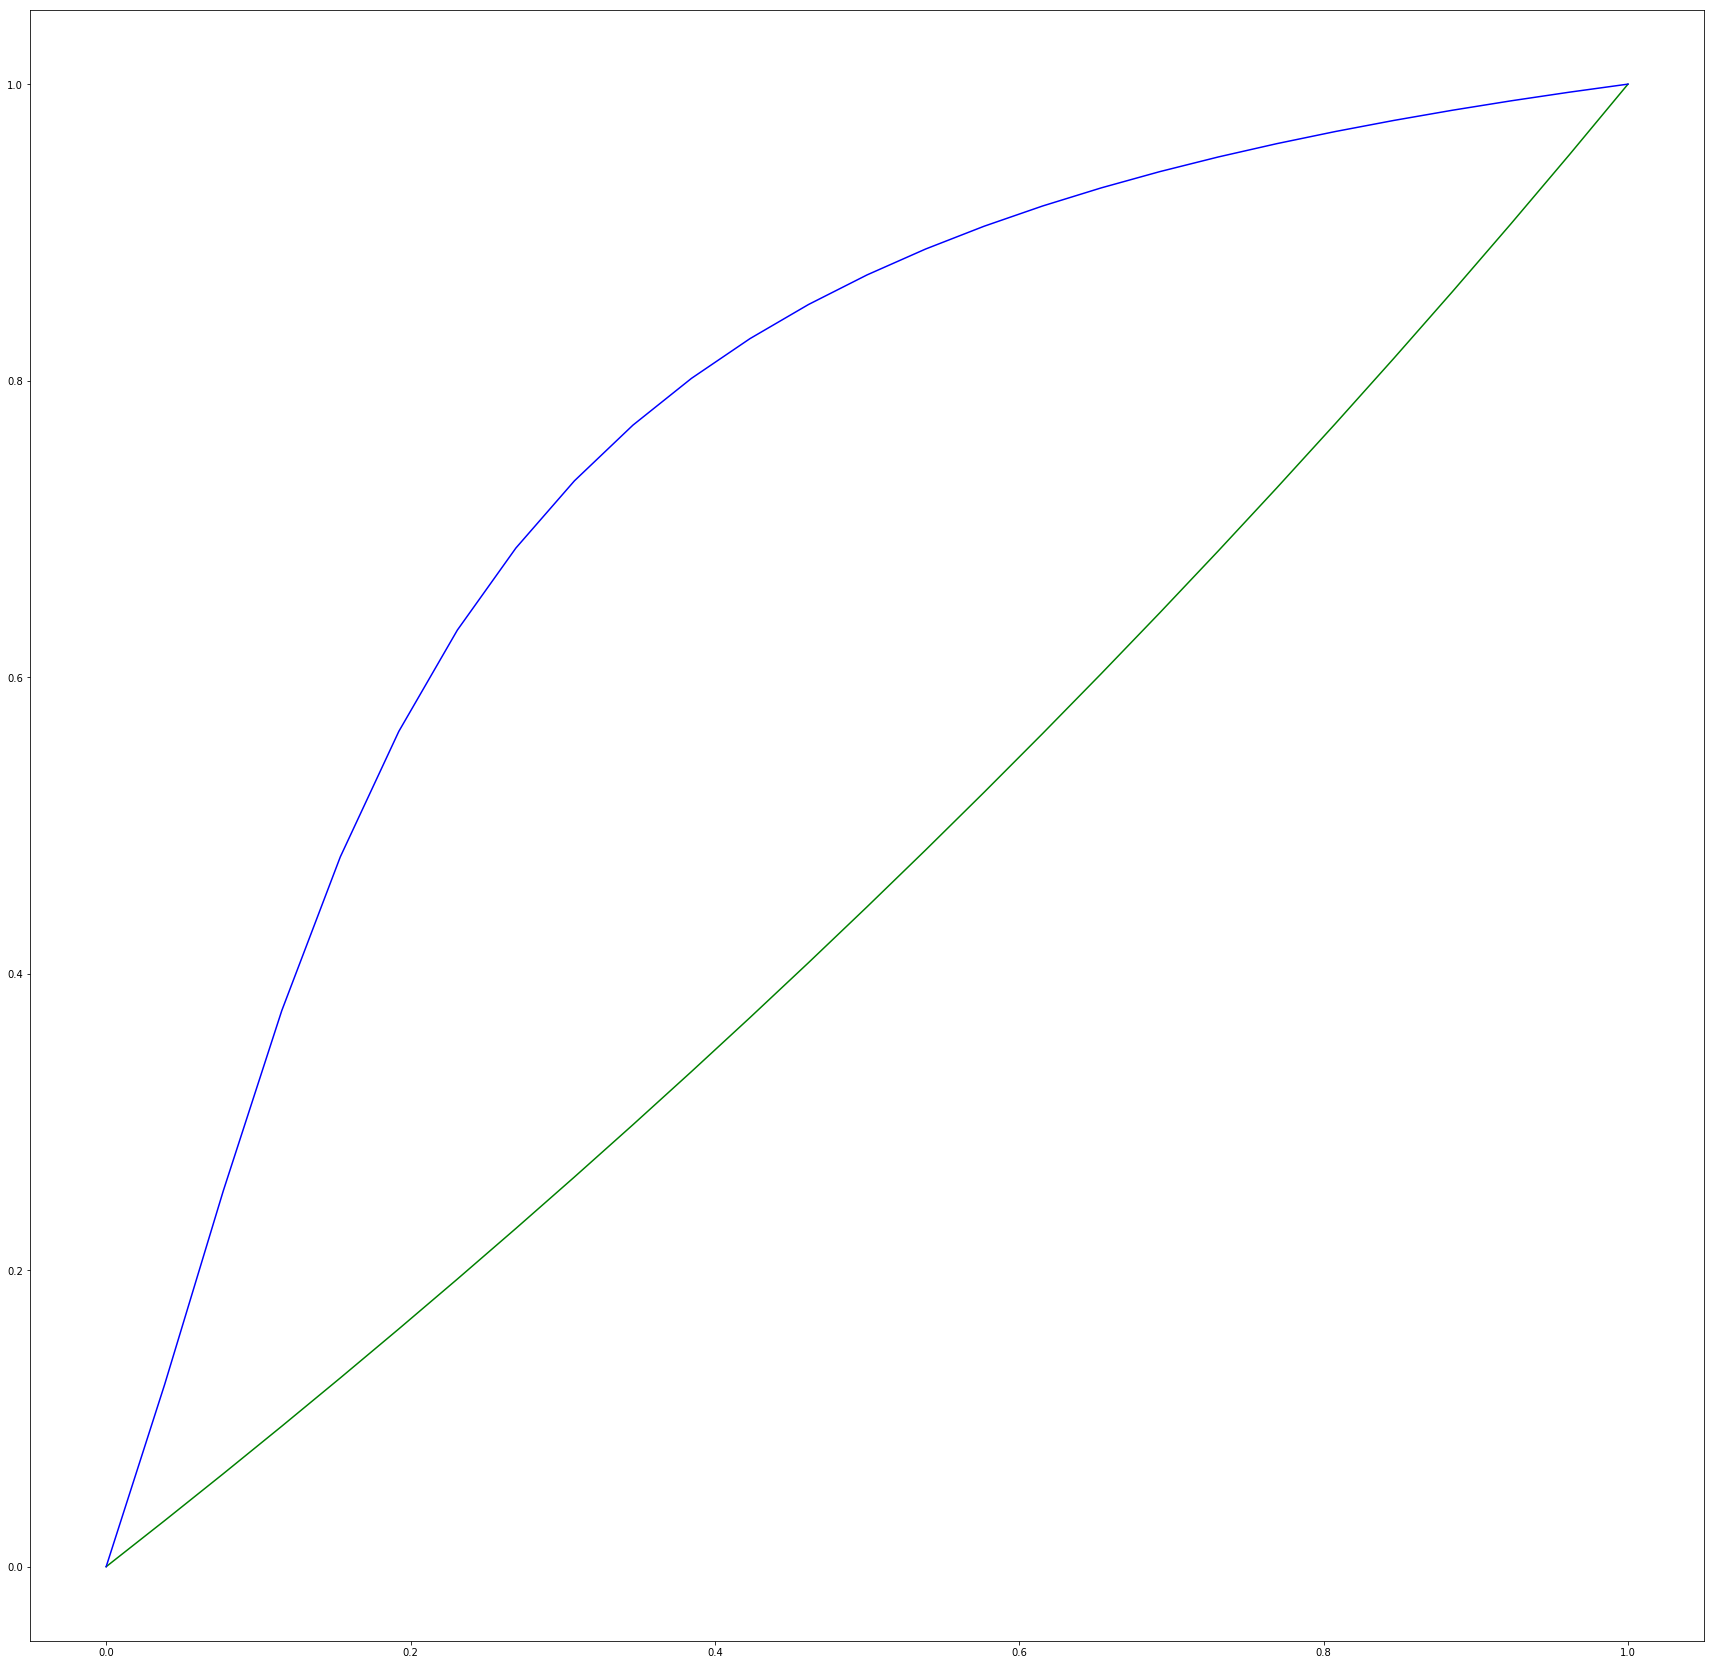

In [77]:
fig, ax = plt.subplots(figsize = (30, 30))
ax.plot(x, y00, color='g')
ax.plot(x, y10, color='b')

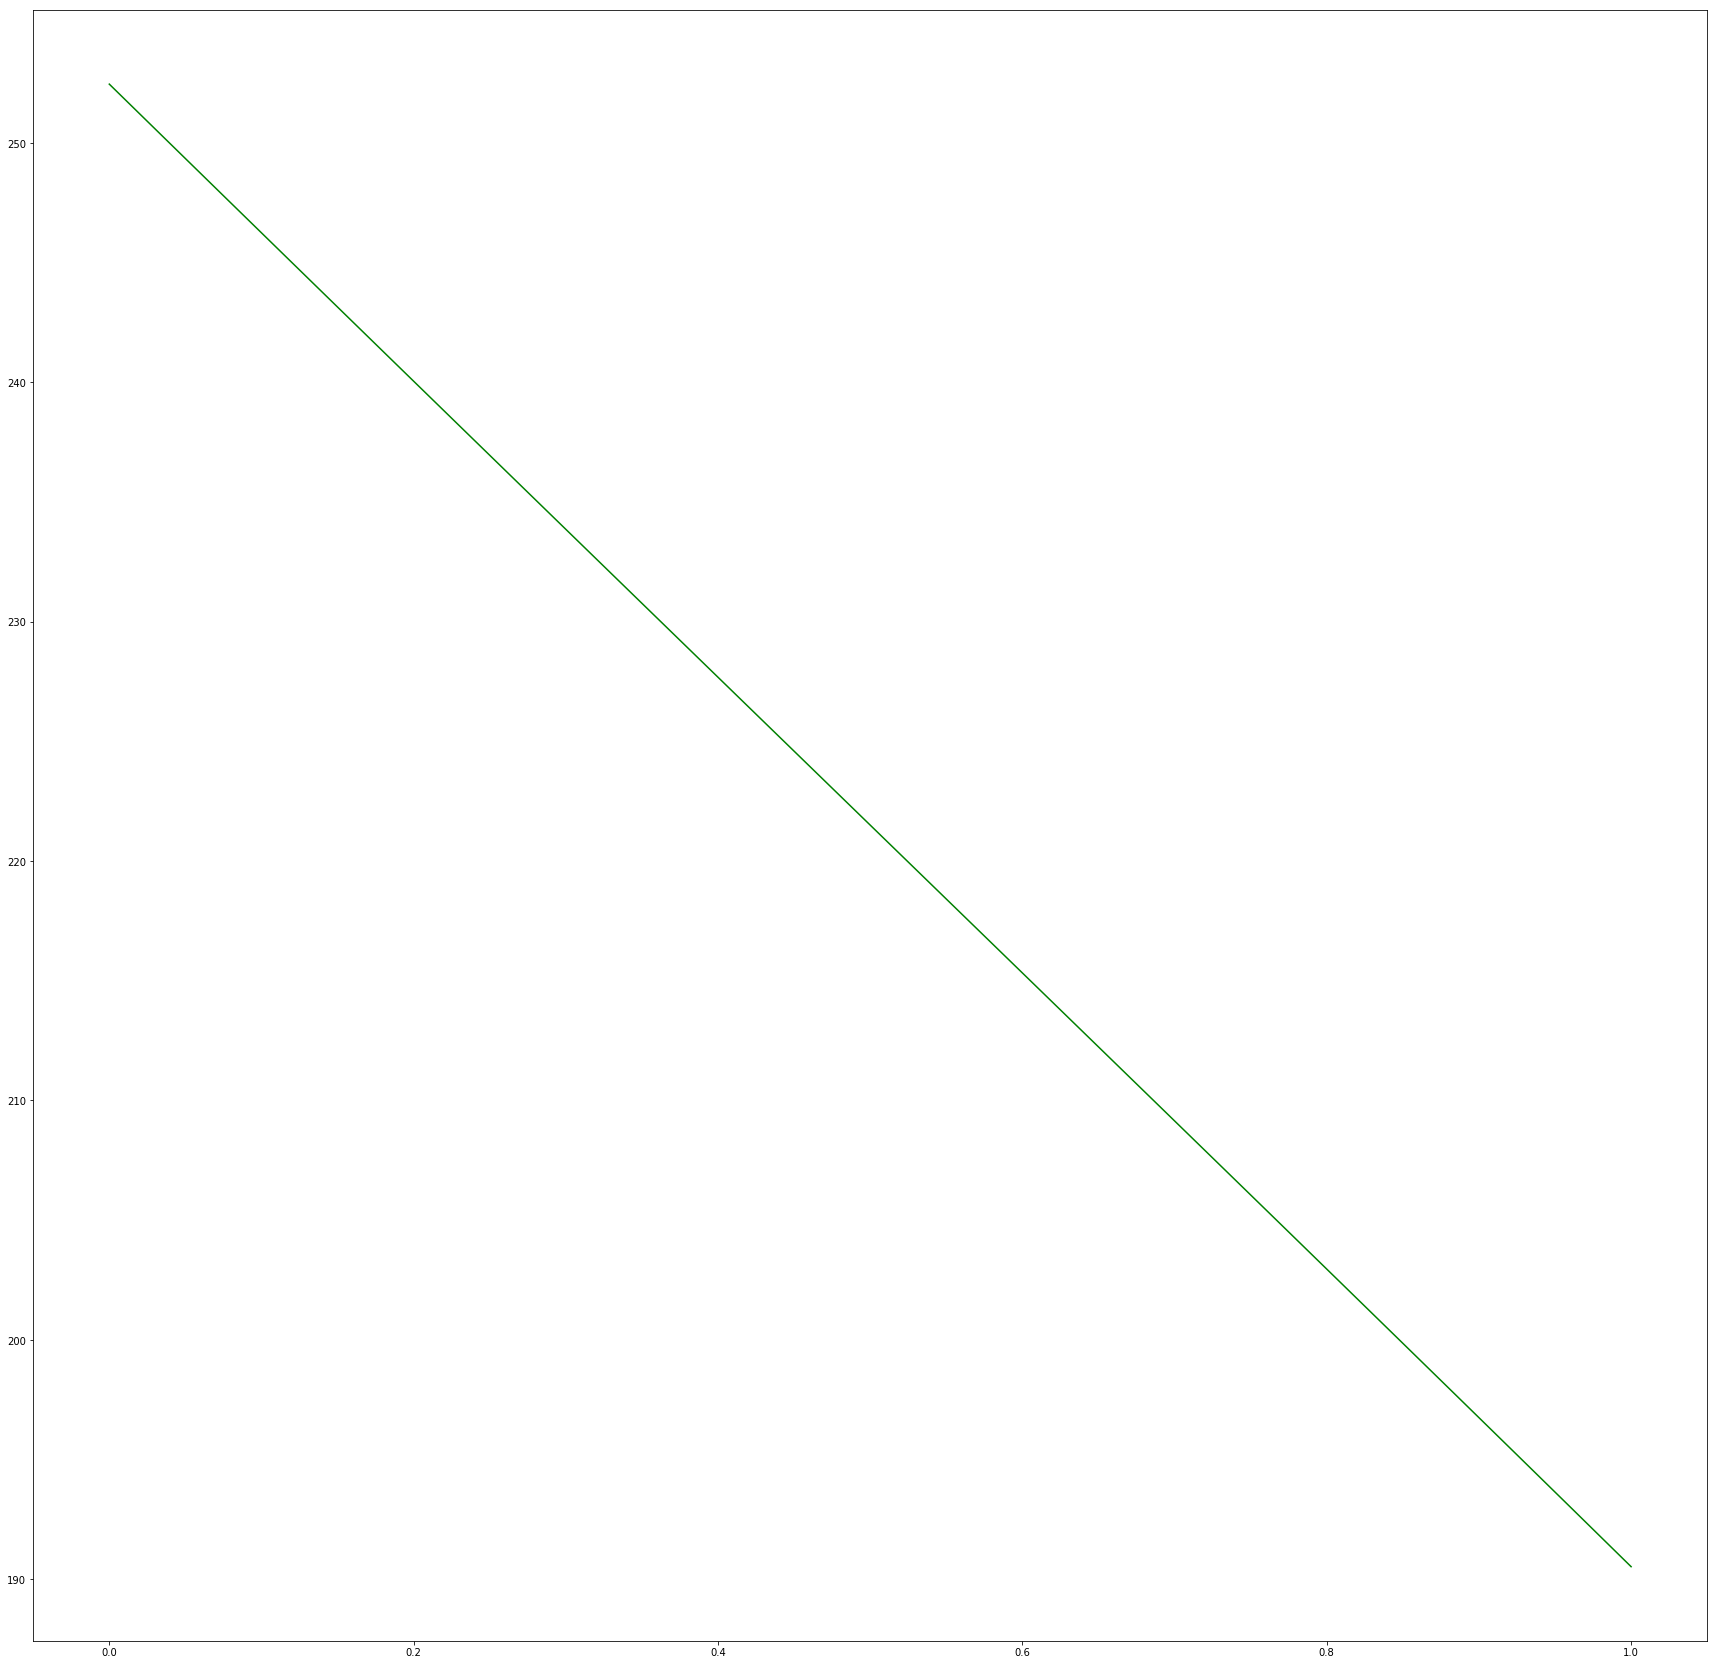

In [78]:
fig, ax = plt.subplots(figsize = (30, 30))
ax.plot(x, y01, color='g')
# ax.plot(x, y11, color='b')

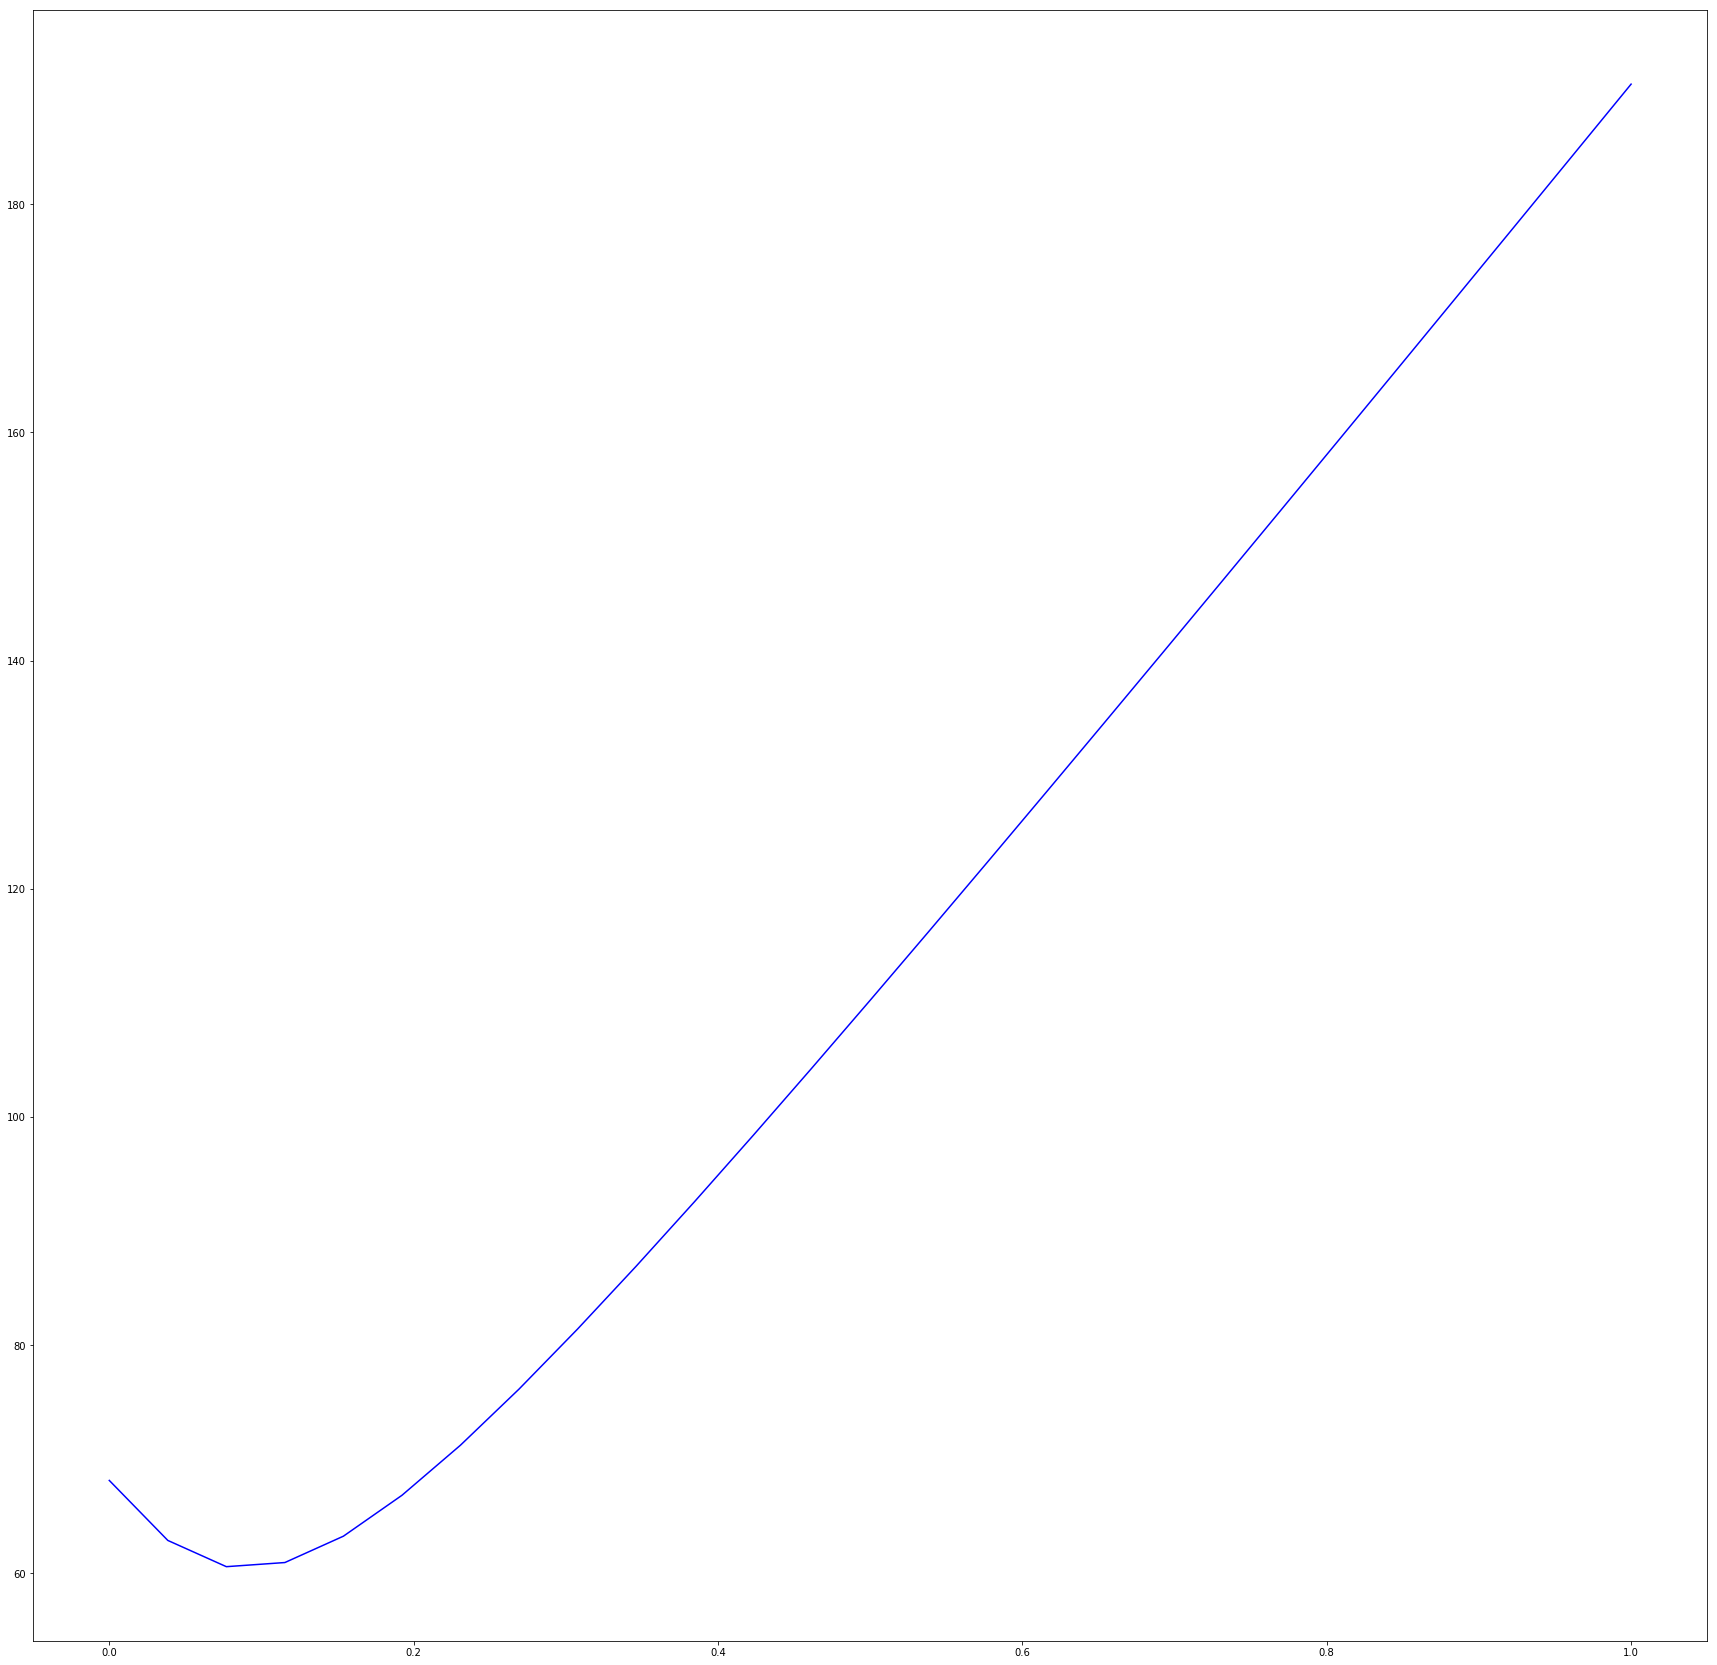

In [79]:
fig, ax = plt.subplots(figsize = (30, 30))
# ax.plot(x, y01, color='g')
ax.plot(x, y11, color='b')